In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from positional_sparse_linear import PositionalSparseLinear, PositionalSparseLinear2d, PositionalSparseLinear3d
from utils import *

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)
!nvidia-smi

Using /home/jl/.cache/torch_extensions/py312_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/jl/.cache/torch_extensions/py312_cu121/positional_sparse_linear_csrc/build.ninja...
/data/Projets/IA/experimentations/venv/lib/python3.12/site-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module positional_sparse_linear_csrc...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.
cuda
Thu Jun 27 21:08:53 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.52.04              Driver Version: 555.52.04      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   58C    P5             18W /   80W |      51MiB /   6144MiB |      4%      Default |
|                                         |                        |                  N/A |
+--------------------

Loading extension module positional_sparse_linear_csrc...


Files already downloaded and verified
Files already downloaded and verified
Train size :  50000
validation size :  10000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.70007944..1.8768656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5248982..1.6645687].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49101883..1.4608634].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42906845..1.7462543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.41458094..1.8768656].


torch.Size([128, 3, 32, 32])
torch.Size([128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.63285315..1.8628243].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6835892..1.6543573].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.37460268..1.3559495].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6014923..1.8768656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.757044].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6549388..1.0983638].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4410

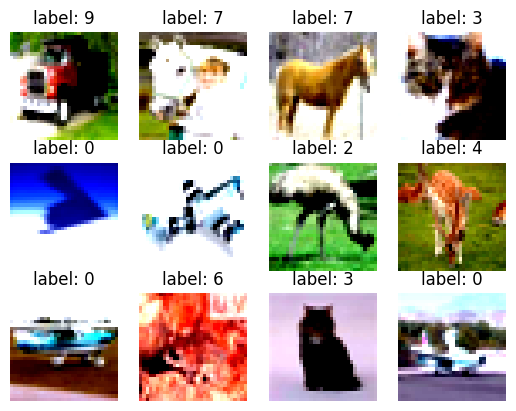

In [2]:
train_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomHorizontalFlip(),
        # torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]
)

train_set = torchvision.datasets.CIFAR10('DATA_CIFAR/', download=True, train=True, transform=train_transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=6)

validation_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]
)

validation_set = torchvision.datasets.CIFAR10('DATA_CIFAR/', download=True, train=False, transform=validation_transform)
validationLoader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=True, num_workers=6)

print("Train size : ", len(train_set))
print("validation size : ", len(validation_set))

training_data = enumerate(trainLoader)
batch_idx, (images, labels) = next(training_data)

print(images.shape)
print(labels.shape)

for i in range(0,12):
    plt.subplot(3, 4, i+1)
    plt.imshow((images[i]/ 2 + 0.5).permute(1,2,0).numpy()); plt.axis('off')
    plt.title("label: " + str(labels[i].numpy().squeeze()))

In [3]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class SimpleResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleResNet, self).__init__()
        self.in_channels = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.layer1 = self._make_layer(16, 2, stride=1)
        self.layer2 = self._make_layer(32, 2, stride=2)
        self.layer3 = self._make_layer(64, 2, stride=2)
        
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

model = SimpleResNet().to(device)
print(trainable_parameters(model))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

175258


Epoch: 1/20   Train loss: 1.3803   Valid loss: 1.2635   Train acc: 0.4961   Valid acc: 0.5606   Elapsed time: 24.7036 sec   Time left: 469.3688 sec
Epoch: 2/20   Train loss: 0.9654   Valid loss: 1.0805   Train acc: 0.6558   Valid acc: 0.6186   Elapsed time: 51.5201 sec   Time left: 482.6954 sec
Epoch: 3/20   Train loss: 0.8015   Valid loss: 1.0526   Train acc: 0.7180   Valid acc: 0.6254   Elapsed time: 71.9890 sec   Time left: 347.9665 sec
Epoch: 4/20   Train loss: 0.6999   Valid loss: 0.9828   Train acc: 0.7540   Valid acc: 0.6742   Elapsed time: 87.6626 sec   Time left: 250.7769 sec
Epoch: 5/20   Train loss: 0.6290   Valid loss: 0.7522   Train acc: 0.7796   Valid acc: 0.7379   Elapsed time: 103.1740 sec   Time left: 232.6685 sec
Epoch: 6/20   Train loss: 0.5830   Valid loss: 0.7024   Train acc: 0.7973   Valid acc: 0.7566   Elapsed time: 121.4794 sec   Time left: 256.2741 sec
Epoch: 7/20   Train loss: 0.5358   Valid loss: 0.5980   Train acc: 0.8149   Valid acc: 0.7913   Elapsed time: 

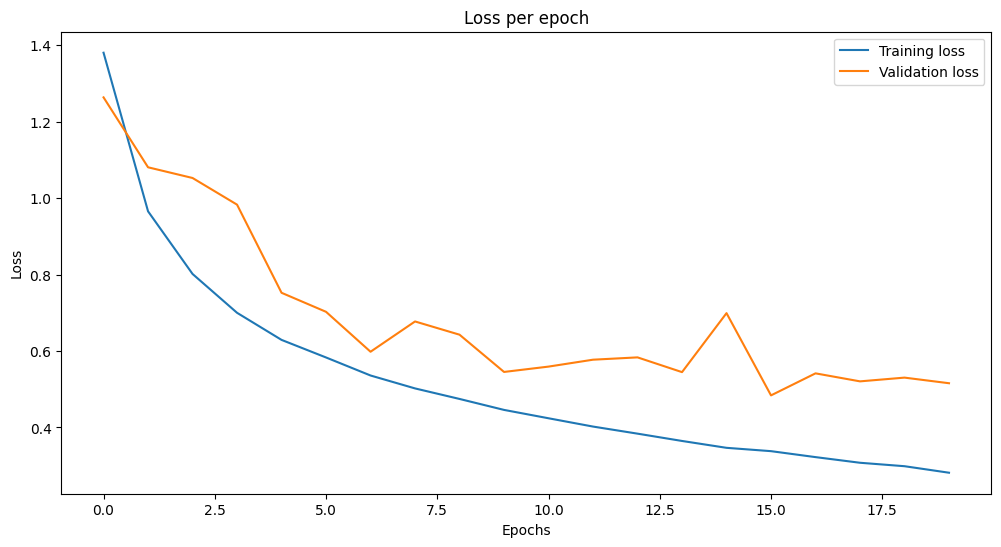

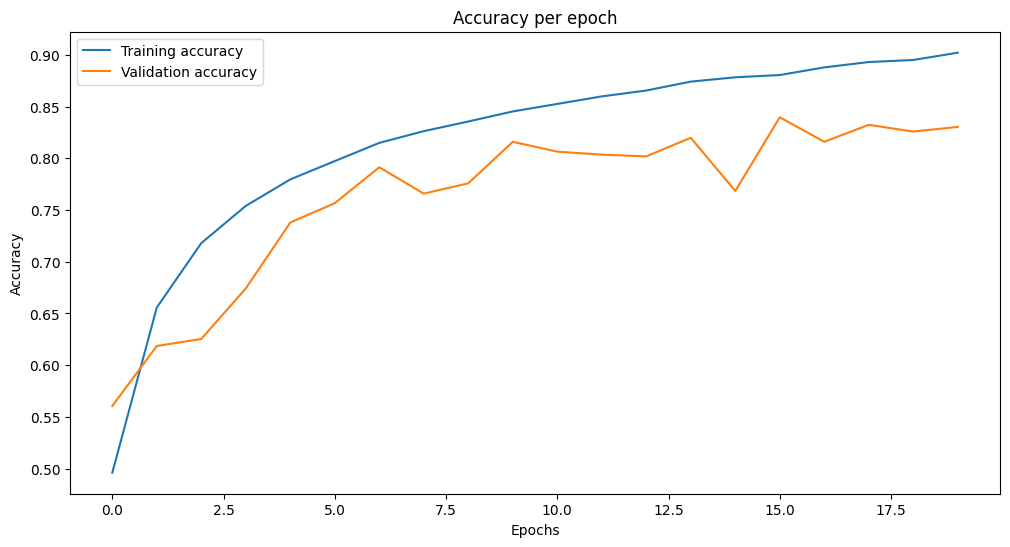

Accuracy of basic linear model:  0.8303


In [4]:
train_loss, val_loss, accuracy_total_train, accuracy_total_val, total_time = train_model(
    model,
    trainLoader,
    validationLoader,
    train_set,
    validation_set,
    criterion,
    optimizer,
    device,
    "model/",
    0,
    20
)

plot_loss(train_loss, val_loss)
plot_accuracy(accuracy_total_train, accuracy_total_val)
print("Accuracy of basic linear model: ", test_accuracy(model, validationLoader, validation_set, device))

In [2]:
class SparseLinearBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(SparseLinearBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.sparse1 = PositionalSparseLinear3d(out_channels, 32 // stride, 32 // stride, 
                                                out_channels, 32 // stride, 32 // stride, 8, 0.1)
        self.sparse2 = PositionalSparseLinear3d(out_channels, 32 // stride, 32 // stride, 
                                                out_channels, 32 // stride, 32 // stride, 8, 0.1)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.sparse1(out)
        out = self.sparse2(out)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class SparseLinearResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(SparseLinearResNet, self).__init__()
        self.in_channels = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.layer1 = self._make_layer(16, 2, stride=1)
        self.layer2 = self._make_layer(32, 2, stride=2)
        self.layer3 = self._make_layer(64, 2, stride=2)
        
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(SparseLinearBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
model = SparseLinearResNet().to(device)
print(trainable_parameters(model))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.00 GiB. GPU 

Epoch: 1/20   Train loss: 1.3659   Valid loss: 1.2237   Train acc: 0.5081   Valid acc: 0.5565   Elapsed time: 19.8507 sec   Time left: 377.1639 sec
Epoch: 2/20   Train loss: 0.9499   Valid loss: 0.9308   Train acc: 0.6651   Valid acc: 0.6739   Elapsed time: 42.7722 sec   Time left: 412.5840 sec
Epoch: 3/20   Train loss: 0.7881   Valid loss: 0.9730   Train acc: 0.7235   Valid acc: 0.6654   Elapsed time: 65.6710 sec   Time left: 389.2766 sec
Epoch: 4/20   Train loss: 0.6903   Valid loss: 0.7335   Train acc: 0.7596   Valid acc: 0.7433   Elapsed time: 85.0989 sec   Time left: 310.8447 sec
Epoch: 5/20   Train loss: 0.6249   Valid loss: 0.6644   Train acc: 0.7826   Valid acc: 0.7680   Elapsed time: 107.7334 sec   Time left: 339.5157 sec
Epoch: 6/20   Train loss: 0.5751   Valid loss: 0.6497   Train acc: 0.8007   Valid acc: 0.7775   Elapsed time: 127.2285 sec   Time left: 272.9249 sec
Epoch: 7/20   Train loss: 0.5384   Valid loss: 0.6535   Train acc: 0.8124   Valid acc: 0.7743   Elapsed time: 

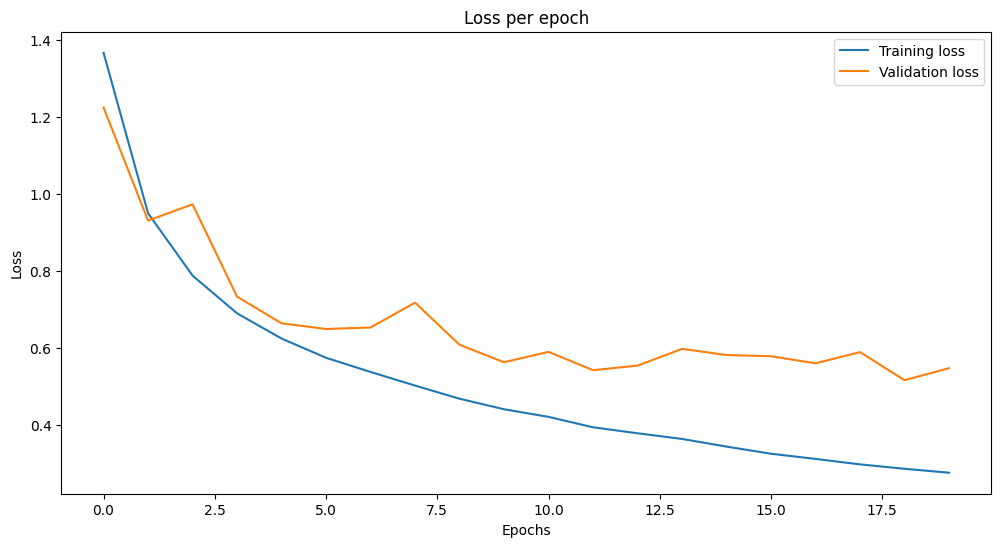

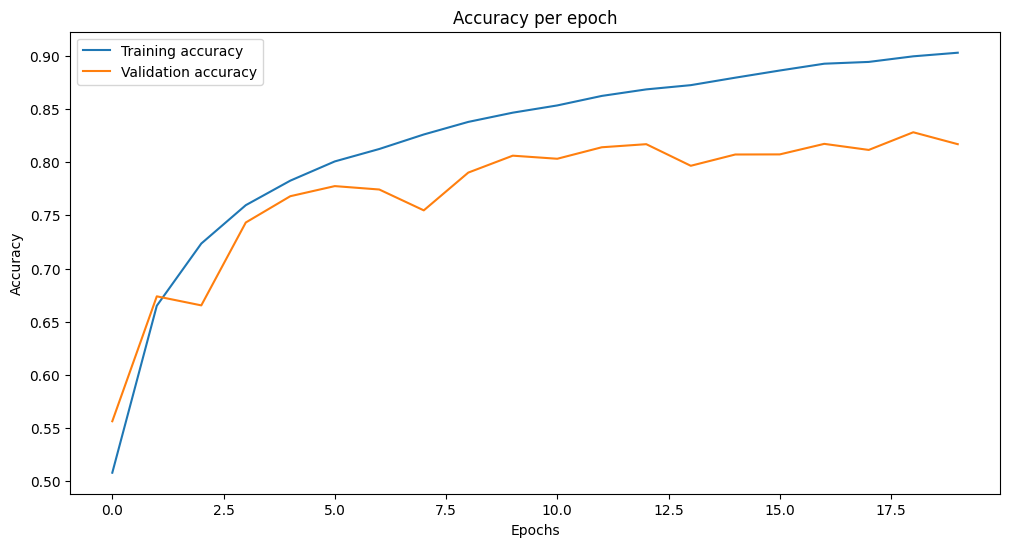

Accuracy of basic linear model:  0.8169


In [6]:
train_loss, val_loss, accuracy_total_train, accuracy_total_val, total_time = train_model(
    model,
    trainLoader,
    validationLoader,
    train_set,
    validation_set,
    criterion,
    optimizer,
    device,
    "model/",
    0,
    20
)

plot_loss(train_loss, val_loss)
plot_accuracy(accuracy_total_train, accuracy_total_val)
print("Accuracy of basic linear model: ", test_accuracy(model, validationLoader, validation_set, device))